# Desafío de Deep Learning en Computer Vision
## Dataset elegido

El problema que elegí resolver es el de reconocer los símbolos del alfabeto de señas.
En Kaggle se encuentra disponible un dataset llamado *ASL Alphabet* (https://www.kaggle.com/datasets/grassknoted/asl-alphabet), que contiene en total 87000 imágenes de 200x200 píxeles cada una, en la que cada una contiene un símbolo del alfabeto de señas. La cantidad de símbolos son 29 en total. 26 para las letras A a la Z y 3 símbolos para "espacio", "borrar" y "nada".


El dataset descargado se encuentra en el folder *dataset*.

El dataset está compuesto por imágenes en formato *jpg*, anidado en subcarpetas según la clase a la que pertenece cada imagen.
Por ejemplo, una imagen correspondiente a la clase "A" (supongamos "A1.jpg") se va a encontrar en "*dataset/asl_alphabet_train/A/A1.jpg*"



In [86]:
import os
import glob
import random
import time
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from datetime import datetime
from PIL import Image
from tqdm.notebook import tqdm

import torch
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
from torchsummary import summary

## Carga del conjunto de datos
Primero observo como están distribuídos los folders dentro del conjunto de train

In [87]:
train_dataset_path = "dataset/asl_alphabet_train/asl_alphabet_train"

subdirectories = os.listdir(train_dataset_path)
print(subdirectories)
print(f"{len(subdirectories)} clases en total.")

['B', 'I', 'K', 'Y', 'del', 'S', 'C', 'V', 'D', 'L', 'T', 'Q', 'W', 'F', 'E', 'H', 'Z', 'G', 'M', 'P', 'X', 'O', 'J', 'U', 'A', 'N', 'nothing', 'space', 'R']
29 clases en total.


Existe un subdirectorio por cada clase existente en el dataset. En cada subdirectorios existen solo archivos .jpg correspondientes a imágenes con manos representando la letra del alfabeto del subdirectorio al que pertenece, o alguno de los tres símbolos que no son letra ("nothing", "space", "del").

Voy a generar un DataFrame con la inormación del dataset para poder luego hacer *shuffle* y *splitting* de este.

In [88]:
elementos = []

for subdir in subdirectories:
    files = glob.glob(f"{train_dataset_path}/{subdir}/*.jpg")
    print(f"[i] Clase '{subdir}' tiene {len(files)} archivos .jpg")
    for file in files:
        elementos.append({
            'class': subdir,
            'path': file
        })
dataset_df = pd.DataFrame(elementos)
    

[i] Clase 'B' tiene 3000 archivos .jpg
[i] Clase 'I' tiene 3000 archivos .jpg
[i] Clase 'K' tiene 3000 archivos .jpg
[i] Clase 'Y' tiene 3000 archivos .jpg
[i] Clase 'del' tiene 3000 archivos .jpg
[i] Clase 'S' tiene 3000 archivos .jpg
[i] Clase 'C' tiene 3000 archivos .jpg
[i] Clase 'V' tiene 3000 archivos .jpg
[i] Clase 'D' tiene 3000 archivos .jpg
[i] Clase 'L' tiene 3000 archivos .jpg
[i] Clase 'T' tiene 3000 archivos .jpg
[i] Clase 'Q' tiene 3000 archivos .jpg
[i] Clase 'W' tiene 3000 archivos .jpg
[i] Clase 'F' tiene 3000 archivos .jpg
[i] Clase 'E' tiene 3000 archivos .jpg
[i] Clase 'H' tiene 3000 archivos .jpg
[i] Clase 'Z' tiene 3000 archivos .jpg
[i] Clase 'G' tiene 3000 archivos .jpg
[i] Clase 'M' tiene 3000 archivos .jpg
[i] Clase 'P' tiene 3000 archivos .jpg
[i] Clase 'X' tiene 3000 archivos .jpg
[i] Clase 'O' tiene 3000 archivos .jpg
[i] Clase 'J' tiene 3000 archivos .jpg
[i] Clase 'U' tiene 3000 archivos .jpg
[i] Clase 'A' tiene 3000 archivos .jpg
[i] Clase 'N' tiene 300

In [89]:
print("Algunos elementos al azar: \n")
random_sample = dataset_df.sample(5)
print(random_sample)
print(f"\nShape del conjunto de datos de train: {dataset_df.shape}")

Algunos elementos al azar: 

      class                                               path
42794     E  dataset/asl_alphabet_train/asl_alphabet_train/...
68086     J  dataset/asl_alphabet_train/asl_alphabet_train/...
75032     N  dataset/asl_alphabet_train/asl_alphabet_train/...
33244     Q  dataset/asl_alphabet_train/asl_alphabet_train/...
16392     S  dataset/asl_alphabet_train/asl_alphabet_train/...

Shape del conjunto de datos de train: (87000, 2)


Verifico que construí bien los paths intentando abrir el sampleo que hice.

Class: E


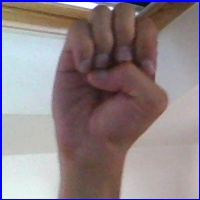

---
Class: J


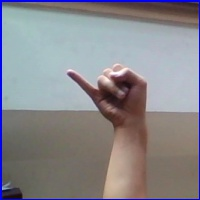

---
Class: N


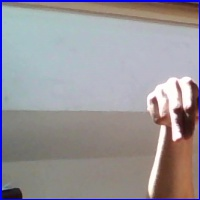

---
Class: Q


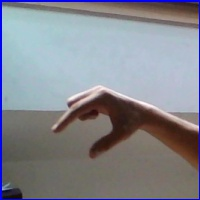

---
Class: S


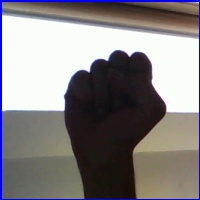

---


In [90]:
from IPython.display import display
for _, row in random_sample.iterrows():
    print("Class:", row["class"])
    display(Image.open(row["path"]))
    print("---")

En cuanto a la distribución de los elementos, puede verse que cada clase tiene exactamente 3000 elementos, por lo que está balanceado. Hacemos el gráfico de barras para confirmarlo solamente:

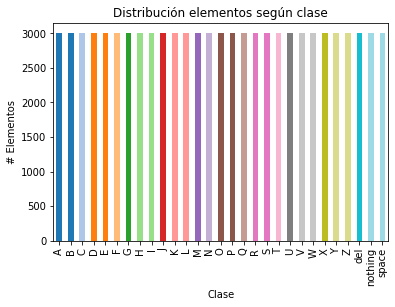

In [91]:
def dist_dataframe(df):
    cmap = plt.get_cmap('tab20')
    class_counts = df.value_counts("class").sort_index()
    colors = cmap(np.linspace(0,1,len(class_counts)))

    ax = class_counts.plot(kind='bar', color=colors)#["mediumseagreen", "lightseagreen"], )
    ax.set_xlabel("Clase")
    ax.set_ylabel("# Elementos")
    ax.set_title("Distribución elementos según clase")
dist_dataframe(dataset_df)

El siguiente paso es hacer *shuffling* y *splitting* del conjunto de *train*. Lo divido en subconjuntos de *train* y *validation* y van a ser usados para entrenar y evaluar el entrenamiento al final de cada *epoch*.  
El conjunto de *test* disponible contiene solo una imagen por clase, argumentando en la especificación del *dataset* que es para motivar el uso de imágenes reales. Una decisión posible podría ser la de generar también un conjunto de *test* en el proceso de *shuffling* y *splitting* del conjunto que cargamos. Sin embargo, si se observan elementos consecutivos de una misma clase, puede observarse que son practicamente iguales, solo que varió un poco la posición de la mano.  
Podría existir entonces el riesgo de que estemos haciendo *overfitting*, y que si usamos un conjunto de *test* con elementos casi iguales a los pertenecientes a *train* y *validation* no nos demos cuenta. Lo mejor sería hacer un conjunto de imágenes completamente distinas para evaluar los modelos finales y compararlos.  

En este sentido, hice una búsqueda en Kaggle y encontré "*ASL Alphabet Test*" (https://www.kaggle.com/datasets/danrasband/asl-alphabet-test), un conjunto de 870 imágenes de 200x200 píxeles, 30 imágenes por cada una de las 29 clases. Voy a hacer uso de este conjunto para hacer la evaluación final.
 
A continuación hago *shuffling* y *splitting* del *dataset* actual. Las proporciones usadas para subdividir son 80\% para *train* y 20\% para *validation*.

In [92]:

# Voy a definir la seed de las librerías usadas para generar reproducibilidad
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)


In [93]:
mask = np.random.rand(len(dataset_df)) < 0.8
train_df = dataset_df[mask]
val_df = dataset_df[~mask]

Chequeo la distriución de los dos conjuntos obtenidos, aunque es de esperarse que lo estén dado que el conjunto inicial estaba perfectamente balanceado.

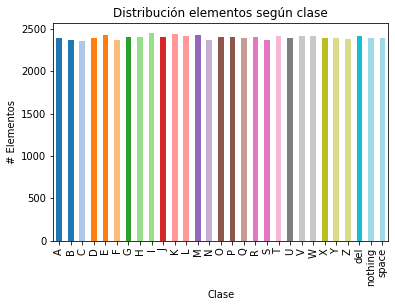

In [94]:
dist_dataframe(train_df)

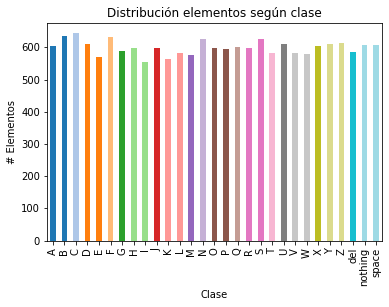

In [95]:
dist_dataframe(val_df)

Ahora voy a escribir el manejador del dataset. Por practicidad queda implementado en un archivo aparte (*ASLDataset.py*).
Implementé la posibilidad de precargar todo en memoria al principio, dado que si se estuviese trabajando en algo con una buena cantidad de recursos (podría ser un cluster) mejoraría la velocidad de procesamiento, ya que las imágenes las tendríamos en memoria RAM o GPU, no teniendo que cargarlas una a una al momento de usarla.
Sin embargo, no fue posible en mi caso precargar todo, por lo que utilicé el manejador de dataset sin precargar.

Las transformaciones que hago a las imágenes son la de ajustar el tamaño a 64x64 y ToTensor, que además de transformar la imagen a un tensor, lo normaliza, pasando cada valor de pixel de [0,255] a [0,1], que facilita el aprendizaje del modelo.
        

In [96]:
from ASLDataset import ASLDataset

ind_to_class = sorted(list(set(dataset_df["class"].values)))
class_to_ind = {
    cl: ind for ind, cl in enumerate(ind_to_class)
}
print(class_to_ind)

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

train_dataset = ASLDataset(train_df, transforms=transform, load_mem=False, class_map=class_to_ind)
val_dataset = ASLDataset(val_df, transforms=transform, load_mem=False, class_map=class_to_ind)

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'del': 26, 'nothing': 27, 'space': 28}


Pruebo obtener un elemento del dataset

ind: 50494
class: 14 (O)
img shape: torch.Size([3, 64, 64])


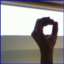

----
ind: 13781
class: 20 (U)
img shape: torch.Size([3, 64, 64])


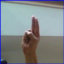

----


In [97]:
def show_rand_sample(dataset):
    rand_int = random.randint(0, len(dataset))
    rand_sample = dataset[rand_int]

    img_tensor = rand_sample[0]
    print(f"ind: {rand_int}\nclass: {rand_sample[1]} ({ind_to_class[rand_sample[1]]})\nimg shape: {img_tensor.shape}")
    trans = transforms.ToPILImage()
    img = trans(img_tensor)
    display(img)
    print("----")

show_rand_sample(train_dataset)
show_rand_sample(val_dataset)

Cargo los DataLoaders que se encargarán de manejar los elementos del dataset (generar los *minibatches*, hacer *shuffling* del dataset en cada *epoch*, etc). El batch elegido es 64, aunque no se realizaron pruebas previas para buscar un tamaño de batch que mejore el aprendizaje.

In [98]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True, num_workers=4)

Reviso un batch de ejemplo

In [99]:
example_batch = next(iter(train_dataloader))
print(f"Shapes:\n Imgs: {example_batch[0].shape}\n Labels: {len(example_batch[1])}")

Shapes:
 Imgs: torch.Size([64, 3, 64, 64])
 Labels: 64


## Entrenamiento del modelo CNN convencional

El primer *approach* es la implementación de una red neuronal Convolucional. Este quedó implementado en el archivo *CNN.py*
A continuación importo el modelo y muestro su arquitectura.

In [100]:
from CNN import CNN

device = 'cuda' if torch.cuda.is_available() else 'cpu'
CNN_model = CNN(29).to(device)

summary(CNN_model, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 62, 62]             896
              ReLU-2           [-1, 32, 62, 62]               0
         MaxPool2d-3           [-1, 32, 31, 31]               0
           Dropout-4           [-1, 32, 31, 31]               0
            Conv2d-5           [-1, 64, 29, 29]          18,496
              ReLU-6           [-1, 64, 29, 29]               0
         MaxPool2d-7           [-1, 64, 14, 14]               0
           Dropout-8           [-1, 64, 14, 14]               0
            Conv2d-9          [-1, 128, 12, 12]          73,856
             ReLU-10          [-1, 128, 12, 12]               0
        MaxPool2d-11            [-1, 128, 6, 6]               0
          Dropout-12            [-1, 128, 6, 6]               0
           Conv2d-13            [-1, 128, 2, 2]         147,584
             ReLU-14            [-1, 12

Pruebo ejecutar un batch en el modelo para ver que todo ejecuta sin reventar.

In [101]:
example_output = CNN_model(example_batch[0])
print(example_output)
print(example_output.shape)

tensor([[0.0323, 0.0352, 0.0322,  ..., 0.0348, 0.0309, 0.0352],
        [0.0323, 0.0349, 0.0319,  ..., 0.0343, 0.0314, 0.0354],
        [0.0318, 0.0350, 0.0321,  ..., 0.0342, 0.0316, 0.0359],
        ...,
        [0.0320, 0.0352, 0.0322,  ..., 0.0343, 0.0315, 0.0361],
        [0.0319, 0.0349, 0.0326,  ..., 0.0341, 0.0313, 0.0355],
        [0.0324, 0.0348, 0.0323,  ..., 0.0341, 0.0315, 0.0359]],
       grad_fn=<SoftmaxBackward>)
torch.Size([64, 29])


Ahora voy a generar la función para entrenar el modelo

In [187]:
def train_epoch(model, dataloader, criterion, optimizer, device='cpu'):
    model.train()
    stats = {
        'losses': [],
        'correct': 0,
        'total': 0,
    }
    # Recorremos el dataset por batches iterando sobre el dataloader
    for _, (images, trg_labels) in enumerate(tqdm(dataloader)):
        images.to(device)
        trg_labels.to(device)
        output = model(images)
        loss = criterion(output, trg_labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        stats["losses"].append(loss.item())
        preds = output.argmax(dim=1).reshape(-1)
        stats["correct"] += (preds == trg_labels).sum()
        stats["total"] += images.shape[0]
    return stats
    
def evaluate(model, dataloader, criterion, device='cpu'):
    model.eval()
    stats = {
        'losses': [],
        'correct': 0,
        'total': 0,
        'preds': []
    }

    for _, (images, trg_labels) in enumerate(tqdm(dataloader)):
        images.to(device)
        trg_labels.to(device)
        output = model(images)
        loss = criterion(output, trg_labels)
        
        stats['losses'].append(loss.item())
        preds = output.argmax(dim=1).reshape(-1)
        stats['preds'].append([(x[0].item(), x[1].item()) for x in zip(preds, trg_labels)])
        stats['correct'] += (preds == trg_labels).sum()
        stats['total'] += images.shape[0]
    stats['preds'] = sum(stats['preds'], [])
    return stats

In [114]:
criterion = CrossEntropyLoss()
optimizer = torch.optim.Adam(CNN_model.parameters()) # Learning Rate por defecto es 0.001, no se realizaron pruebas de hiperparametrización por el tiempo que me llevaría.

def train_model(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=10, model_name=None, device='cpu'):
    timestamp = datetime.now().strftime("%y%m%d%H%M")
    EPOCHS = epochs
    train_stats = []

    for ind_epoch in range(EPOCHS):
        print(f"[i] Epoch {ind_epoch+1}/{EPOCHS}")
        epoch_stats = {}
        print(f"--[i] Train")
        t0 = time.time()
        epoch_stats['train'] = train_epoch(model, train_dataloader, criterion, optimizer, device=device)
        t1 = time.time()
        train_time = t1-t0
        epoch_stats['train']['time'] = train_time

        print(f"--[i] Validation")
        epoch_stats['val'] = evaluate(model, val_dataloader, criterion, device=device)
        t2 = time.time()
        val_time = t2-t1
        epoch_stats['val']['time'] = val_time

        train_stats.append(epoch_stats)

        # Muestro stats de train y validation
        train_loss = np.mean(epoch_stats['train']['losses'])
        train_acc = float(epoch_stats['train']['correct']) / epoch_stats['train']['total']
        val_loss = np.mean(epoch_stats['val']['losses'])
        val_acc = float(epoch_stats['val']['correct']) / epoch_stats['val']['total']
        print(f"--[i] train_time: {train_time}s, val_time: {val_time}")
        print(f"--[i] train_loss: {train_loss}, train_acc: {train_acc}, val_loss: {val_loss}, val_acc: {val_acc}")

        # Genero un checkpoint para esta epoch
        checkpoint = {
            "epoch": ind_epoch+1,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "class_to_ind": class_to_ind,
            "stats": train_stats,
            "val_loss": val_loss
        }
        model_name_path = f"_{model_name}" if model_name else ""
        checkpoint_path = f"checkpoints/model{model_name_path}_{timestamp}_e{ind_epoch+1}.pt"
        torch.save(checkpoint, checkpoint_path)
    return train_stats


In [19]:
train_model(CNN_model, criterion, optimizer, train_dataloader, val_dataloader, epochs=30, model_name="CNN-propio", device=device)

[i] Epoch 1/30
--[i] Train


  0%|          | 0/1088 [00:00<?, ?it/s]

--[i] Validation


  0%|          | 0/272 [00:00<?, ?it/s]

--[i] train_time: 230.75086784362793s, val_time: 22.351097106933594
--[i] train_loss: 3.2410200895632015, train_acc: 0.1798609714761727, val_loss: 3.1483556233784733, val_acc: 0.2771382525612985
[i] Epoch 2/30
--[i] Train


  0%|          | 0/1088 [00:00<?, ?it/s]

--[i] Validation


  0%|          | 0/272 [00:00<?, ?it/s]

--[i] train_time: 239.45192050933838s, val_time: 22.45236039161682
--[i] train_loss: 3.1064822748303413, train_acc: 0.31832935972194293, val_loss: 3.0499247628099777, val_acc: 0.3760216415333257
[i] Epoch 3/30
--[i] Train


  0%|          | 0/1088 [00:00<?, ?it/s]

--[i] Validation


  0%|          | 0/272 [00:00<?, ?it/s]

--[i] train_time: 226.77908277511597s, val_time: 23.832051515579224
--[i] train_loss: 3.0162894460646545, train_acc: 0.40930112314365324, val_loss: 2.951582764001454, val_acc: 0.4743870150800046
[i] Epoch 4/30
--[i] Train


  0%|          | 0/1088 [00:00<?, ?it/s]

--[i] Validation


  0%|          | 0/272 [00:00<?, ?it/s]

--[i] train_time: 235.8389995098114s, val_time: 21.422853231430054
--[i] train_loss: 2.9309230505981865, train_acc: 0.4950736793726481, val_loss: 2.8812495987204945, val_acc: 0.5463336019339242
[i] Epoch 5/30
--[i] Train


  0%|          | 0/1088 [00:00<?, ?it/s]

--[i] Validation


  0%|          | 0/272 [00:00<?, ?it/s]

--[i] train_time: 229.0034739971161s, val_time: 22.05636239051819
--[i] train_loss: 2.860607966123258, train_acc: 0.5657656622526068, val_loss: 2.809851473745178, val_acc: 0.6170139288592149
[i] Epoch 6/30
--[i] Train


  0%|          | 0/1088 [00:00<?, ?it/s]

--[i] Validation


  0%|          | 0/272 [00:00<?, ?it/s]

--[i] train_time: 226.90645837783813s, val_time: 21.947332859039307
--[i] train_loss: 2.7986300427685764, train_acc: 0.6278976244506362, val_loss: 2.7408753519549087, val_acc: 0.6857373086220789
[i] Epoch 7/30
--[i] Train


  0%|          | 0/1088 [00:00<?, ?it/s]

--[i] Validation


  0%|          | 0/272 [00:00<?, ?it/s]

--[i] train_time: 228.22565937042236s, val_time: 22.777009963989258
--[i] train_loss: 2.756681325681069, train_acc: 0.6692614827794214, val_loss: 2.7101976801367367, val_acc: 0.7155519742143432
[i] Epoch 8/30
--[i] Train


  0%|          | 0/1088 [00:00<?, ?it/s]

--[i] Validation


  0%|          | 0/272 [00:00<?, ?it/s]

--[i] train_time: 229.38429427146912s, val_time: 21.416228771209717
--[i] train_loss: 2.7273636061479065, train_acc: 0.6986757820354466, val_loss: 2.696972566492417, val_acc: 0.7289052607344307
[i] Epoch 9/30
--[i] Train


  0%|          | 0/1088 [00:00<?, ?it/s]

--[i] Validation


  0%|          | 0/272 [00:00<?, ?it/s]

--[i] train_time: 218.89314103126526s, val_time: 20.69320011138916
--[i] train_loss: 2.7042055318460747, train_acc: 0.7214689914687042, val_loss: 2.666742905974388, val_acc: 0.7579716818234143
[i] Epoch 10/30
--[i] Train


  0%|          | 0/1088 [00:00<?, ?it/s]

--[i] Validation


  0%|          | 0/272 [00:00<?, ?it/s]

--[i] train_time: 217.21355509757996s, val_time: 21.389153718948364
--[i] train_loss: 2.684899914790602, train_acc: 0.7403412518312125, val_loss: 2.651309426216518, val_acc: 0.7747208472430068
[i] Epoch 11/30
--[i] Train


  0%|          | 0/1088 [00:00<?, ?it/s]

--[i] Validation


  0%|          | 0/272 [00:00<?, ?it/s]

--[i] train_time: 221.67574191093445s, val_time: 23.87062954902649
--[i] train_loss: 2.6710622374187496, train_acc: 0.7542441042139431, val_loss: 2.647054891375934, val_acc: 0.779037642454242
[i] Epoch 12/30
--[i] Train


  0%|          | 0/1088 [00:00<?, ?it/s]

--[i] Validation


  0%|          | 0/272 [00:00<?, ?it/s]

--[i] train_time: 245.01680254936218s, val_time: 21.452969312667847
--[i] train_loss: 2.663384317256072, train_acc: 0.7618131157900784, val_loss: 2.629852619241266, val_acc: 0.7953839069874525
[i] Epoch 13/30
--[i] Train


  0%|          | 0/1088 [00:00<?, ?it/s]

--[i] Validation


  0%|          | 0/272 [00:00<?, ?it/s]

--[i] train_time: 249.56129002571106s, val_time: 23.68559741973877
--[i] train_loss: 2.6536982166854775, train_acc: 0.7713354206761842, val_loss: 2.613233075422399, val_acc: 0.8122481869460113
[i] Epoch 14/30
--[i] Train


  0%|          | 0/1088 [00:00<?, ?it/s]

--[i] Validation


  0%|          | 0/272 [00:00<?, ?it/s]

--[i] train_time: 241.29286861419678s, val_time: 22.099570989608765
--[i] train_loss: 2.646842571304125, train_acc: 0.7780570476546118, val_loss: 2.618118386058246, val_acc: 0.8073558190399448
[i] Epoch 15/30
--[i] Train


  0%|          | 0/1088 [00:00<?, ?it/s]

--[i] Validation


  0%|          | 0/272 [00:00<?, ?it/s]

--[i] train_time: 240.88428020477295s, val_time: 22.219934701919556
--[i] train_loss: 2.6391061176272, train_acc: 0.7859851205009623, val_loss: 2.6141905661891487, val_acc: 0.8109819270173823
[i] Epoch 16/30
--[i] Train


  0%|          | 0/1088 [00:00<?, ?it/s]

--[i] Validation


  0%|          | 0/272 [00:00<?, ?it/s]

--[i] train_time: 249.53895044326782s, val_time: 21.423699140548706
--[i] train_loss: 2.638876970857382, train_acc: 0.7859276706977278, val_loss: 2.599528306547333, val_acc: 0.8249107862323012
[i] Epoch 17/30
--[i] Train


  0%|          | 0/1088 [00:00<?, ?it/s]

--[i] Validation


  0%|          | 0/272 [00:00<?, ?it/s]

--[i] train_time: 246.29724717140198s, val_time: 22.458590030670166
--[i] train_loss: 2.6345631269847645, train_acc: 0.790408755350013, val_loss: 2.610465135644464, val_acc: 0.814665592264303
[i] Epoch 18/30
--[i] Train


  0%|          | 0/1088 [00:00<?, ?it/s]

--[i] Validation


  0%|          | 0/272 [00:00<?, ?it/s]

--[i] train_time: 242.13869738578796s, val_time: 21.571144819259644
--[i] train_loss: 2.622352732674164, train_acc: 0.8027748254962227, val_loss: 2.596074442653095, val_acc: 0.8284793369402556
[i] Epoch 19/30
--[i] Train


  0%|          | 0/1088 [00:00<?, ?it/s]

--[i] Validation


  0%|          | 0/272 [00:00<?, ?it/s]

--[i] train_time: 239.95138931274414s, val_time: 22.290072202682495
--[i] train_loss: 2.6277621980099117, train_acc: 0.7970154827219716, val_loss: 2.611929095843259, val_acc: 0.8132266605272246
[i] Epoch 20/30
--[i] Train


  0%|          | 0/1088 [00:00<?, ?it/s]

--[i] Validation


  0%|          | 0/272 [00:00<?, ?it/s]

--[i] train_time: 257.22914719581604s, val_time: 21.633824110031128
--[i] train_loss: 2.6210104943636585, train_acc: 0.8039956338149542, val_loss: 2.603718752370161, val_acc: 0.8207666628295154
[i] Epoch 21/30
--[i] Train


  0%|          | 0/1088 [00:00<?, ?it/s]

--[i] Validation


  0%|          | 0/272 [00:00<?, ?it/s]

--[i] train_time: 233.52674317359924s, val_time: 20.22400164604187
--[i] train_loss: 2.6181043653803715, train_acc: 0.8066670496653549, val_loss: 2.587429001050837, val_acc: 0.8376885000575572
[i] Epoch 22/30
--[i] Train


  0%|          | 0/1088 [00:00<?, ?it/s]

--[i] Validation


  0%|          | 0/272 [00:00<?, ?it/s]

--[i] train_time: 227.53193187713623s, val_time: 20.091997623443604
--[i] train_loss: 2.618253825341954, train_acc: 0.8066239623129291, val_loss: 2.592307702583425, val_acc: 0.8327385748820076
[i] Epoch 23/30
--[i] Train


  0%|          | 0/1088 [00:00<?, ?it/s]

--[i] Validation


  0%|          | 0/272 [00:00<?, ?it/s]

--[i] train_time: 227.508709192276s, val_time: 20.194605827331543
--[i] train_loss: 2.616274129599333, train_acc: 0.8085198058196651, val_loss: 2.5811925267471985, val_acc: 0.8432715551974215
[i] Epoch 24/30
--[i] Train


  0%|          | 0/1088 [00:00<?, ?it/s]

--[i] Validation


  0%|          | 0/272 [00:00<?, ?it/s]

--[i] train_time: 225.9038348197937s, val_time: 20.225607872009277
--[i] train_loss: 2.6168820097604217, train_acc: 0.8079165828857037, val_loss: 2.5872111899011276, val_acc: 0.8370553700932428
[i] Epoch 25/30
--[i] Train


  0%|          | 0/1088 [00:00<?, ?it/s]

--[i] Validation


  0%|          | 0/272 [00:00<?, ?it/s]

--[i] train_time: 224.56988334655762s, val_time: 20.188701629638672
--[i] train_loss: 2.6175335586509285, train_acc: 0.8071697354436561, val_loss: 2.5968842567766415, val_acc: 0.8272130770116266
[i] Epoch 26/30
--[i] Train


  0%|          | 0/1088 [00:00<?, ?it/s]

--[i] Validation


  0%|          | 0/272 [00:00<?, ?it/s]

--[i] train_time: 225.2736518383026s, val_time: 19.81824541091919
--[i] train_loss: 2.6130763868636944, train_acc: 0.8116077327435154, val_loss: 2.5776426634367775, val_acc: 0.8470703349833084
[i] Epoch 27/30
--[i] Train


  0%|          | 0/1088 [00:00<?, ?it/s]

--[i] Validation


  0%|          | 0/272 [00:00<?, ?it/s]

--[i] train_time: 225.64965224266052s, val_time: 20.51899790763855
--[i] train_loss: 2.611388393184718, train_acc: 0.8134030390945911, val_loss: 2.590113287462908, val_acc: 0.8347530793139174
[i] Epoch 28/30
--[i] Train


  0%|          | 0/1088 [00:00<?, ?it/s]

--[i] Validation


  0%|          | 0/272 [00:00<?, ?it/s]

--[i] train_time: 223.86260390281677s, val_time: 20.12181806564331
--[i] train_loss: 2.6124114214497456, train_acc: 0.8124838422428403, val_loss: 2.5742714142098144, val_acc: 0.8508115574997123
[i] Epoch 29/30
--[i] Train


  0%|          | 0/1088 [00:00<?, ?it/s]

--[i] Validation


  0%|          | 0/272 [00:00<?, ?it/s]

--[i] train_time: 229.39003348350525s, val_time: 21.192514657974243
--[i] train_loss: 2.6169229011763546, train_acc: 0.8078447706316606, val_loss: 2.593825597973431, val_acc: 0.8307240704500979
[i] Epoch 30/30
--[i] Train


  0%|          | 0/1088 [00:00<?, ?it/s]

--[i] Validation


  0%|          | 0/272 [00:00<?, ?it/s]

--[i] train_time: 229.24627089500427s, val_time: 21.095816373825073
--[i] train_loss: 2.6079456113717137, train_acc: 0.8168069399362308, val_loss: 2.573929102105253, val_acc: 0.8508115574997123


[{'train': {'losses': [3.367065906524658,
    3.367112874984741,
    3.3672127723693848,
    3.3694958686828613,
    3.3670129776000977,
    3.3664259910583496,
    3.3670830726623535,
    3.3667447566986084,
    3.3660054206848145,
    3.3682050704956055,
    3.366359233856201,
    3.3696048259735107,
    3.3638827800750732,
    3.3687903881073,
    3.3725967407226562,
    3.3693087100982666,
    3.3683738708496094,
    3.3664157390594482,
    3.36789608001709,
    3.3648223876953125,
    3.3669273853302,
    3.368565320968628,
    3.365917205810547,
    3.368126153945923,
    3.366701364517212,
    3.3677310943603516,
    3.3682093620300293,
    3.3666529655456543,
    3.367321014404297,
    3.36617374420166,
    3.3664093017578125,
    3.367605686187744,
    3.3663008213043213,
    3.367391347885132,
    3.366811990737915,
    3.3663086891174316,
    3.366834878921509,
    3.3659331798553467,
    3.367807149887085,
    3.3672454357147217,
    3.3685555458068848,
    3.36560034751892

El mejor modelo obtenido es el de la última *epoch*.
Grafico la evolución del entrenamiento.

In [104]:
checkpoint = torch.load("checkpoints/model_CNN-propio_2204111849_e30.pt")
train_stats = checkpoint['stats']
train_losses = sum([epoch_stats['train']['losses'] for epoch_stats in train_stats], [])
val_losses = sum([epoch_stats['val']['losses'] for epoch_stats in train_stats], [])

val_accs = [float(epoch_stats['val']['correct'])/epoch_stats['val']['total'] for epoch_stats in train_stats]

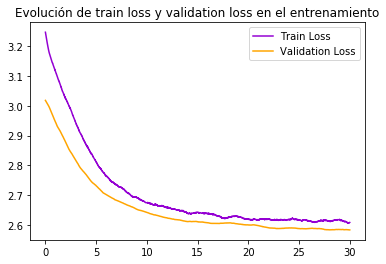

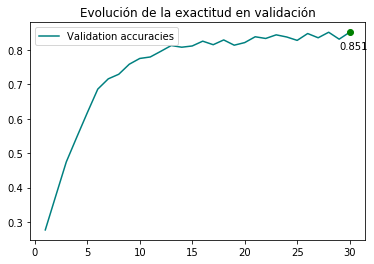

In [115]:
avg_n = 1000

fig, ax = plt.subplots()
epochs = range(1,30)
SALTO = 1000
avged_train = np.convolve(train_losses, np.ones(SALTO)/SALTO, mode='valid') # running mean, https://stackoverflow.com/questions/13728392/moving-average-or-running-mean
avged_val = np.convolve(val_losses, np.ones(SALTO)/SALTO, mode='valid')
ax.plot(np.arange(0, 30, 1/(len(avged_train)/(30))), avged_train, label='Train Loss', color='darkviolet')
ax.plot(np.arange(0, 30, 1/(len(avged_val)/(30))), avged_val, label='Validation Loss', color='orange')
ax.set_title("Evolución de train loss y validation loss en el entrenamiento")
plt.legend()

fig, ax = plt.subplots()
ax.plot(range(1,31), val_accs, label='Validation accuracies', color="teal")
ax.plot(30, val_accs[-1], "go")
ax.text(29, val_accs[-1]-0.05, str(round(val_accs[-1],3)))
ax.set_title("Evolución de la exactitud en validación")
plt.legend()

Si bien el rendimiento alcanzado no es malo (exactitud del 85\% en las predicciones), como se dijo al principio, este conjunto de datos fue generado haciendo uso de frames de videos. Es decir, para cada letra se tomaba un video donde la persona hacía el sígno con la mano, moviéndola. Luego se toman para ese video múltiples frames, generando múltiples elementos del dataset. Intuitivamente esto me lleva a pensar que es muy fácil estar sobreajustando sin darnos cuenta, y que de hecho es el caso más posible dado que cómo los elementos del conjunto de validación fueron tomados del conjunto de entrenamiento inicial, los elementos comparten muchas características.

Una posibilidad para reducir la poca diversidad de imágenes podría ser aumentar los conjuntos generando pequeñas distorsiones en las imágenes: rotándolas, aplicándoles filtros de color, cambiando dilatándolas y recortándolas, etc. De esta forma los conjuntos tendrían para un mismo símbolo una variedad mayor de imágenes correspondientes.

Para corroborar que estamos cayendo en este caso voy a hacer uso del *dataset* de Kaggle *ASL Alphabet Test* (https://www.kaggle.com/datasets/danrasband/asl-alphabet-test) nombrado también al principio.


In [106]:
elementos = []
test_dataset_path = "dataset/test"
for subdir in subdirectories:
    files = glob.glob(f"{test_dataset_path}/{subdir}/*.jpg")
    print(f"[i] Clase '{subdir}' tiene {len(files)} archivos .jpg")
    for file in files:
        elementos.append({
            'class': subdir,
            'path': file
        })
dataset_test_df = pd.DataFrame(elementos)
print(dataset_test_df.shape)

[i] Clase 'B' tiene 30 archivos .jpg
[i] Clase 'I' tiene 30 archivos .jpg
[i] Clase 'K' tiene 30 archivos .jpg
[i] Clase 'Y' tiene 30 archivos .jpg
[i] Clase 'del' tiene 30 archivos .jpg
[i] Clase 'S' tiene 30 archivos .jpg
[i] Clase 'C' tiene 30 archivos .jpg
[i] Clase 'V' tiene 30 archivos .jpg
[i] Clase 'D' tiene 30 archivos .jpg
[i] Clase 'L' tiene 30 archivos .jpg
[i] Clase 'T' tiene 30 archivos .jpg
[i] Clase 'Q' tiene 30 archivos .jpg
[i] Clase 'W' tiene 30 archivos .jpg
[i] Clase 'F' tiene 30 archivos .jpg
[i] Clase 'E' tiene 30 archivos .jpg
[i] Clase 'H' tiene 30 archivos .jpg
[i] Clase 'Z' tiene 30 archivos .jpg
[i] Clase 'G' tiene 30 archivos .jpg
[i] Clase 'M' tiene 30 archivos .jpg
[i] Clase 'P' tiene 30 archivos .jpg
[i] Clase 'X' tiene 30 archivos .jpg
[i] Clase 'O' tiene 30 archivos .jpg
[i] Clase 'J' tiene 30 archivos .jpg
[i] Clase 'U' tiene 30 archivos .jpg
[i] Clase 'A' tiene 30 archivos .jpg
[i] Clase 'N' tiene 30 archivos .jpg
[i] Clase 'nothing' tiene 30 archivo

In [107]:
test_dataset = ASLDataset(dataset_test_df, transforms=transform, load_mem=False, class_map=class_to_ind)
test_dataloader = DataLoader(test_dataset, batch_size=64)
CNN_model.load_state_dict(checkpoint['model_state_dict'])


<All keys matched successfully>

In [188]:
def conf_matrix(preds, num_classes):
    cm = np.zeros((num_classes, num_classes))
    for pred in preds:
        cm[pred[1], pred[0]] += 1 # pred[1] gold, pred[0] pred
    return cm
    
def plot_conf_mat(preds, ind_to_class, title=None):
    num_classes = len(ind_to_class)
    cm = conf_matrix(preds, num_classes)
    df_cm = pd.DataFrame(cm, index=[ind_to_class[i] for i in range(num_classes)], columns=[ind_to_class[i] for i in range(num_classes)])
    fig, ax = plt.subplots(figsize = (10,7))
    ax.set_title(title)
    ax.legend()
    sn.heatmap(df_cm, annot=True)

In [189]:
criterion = CrossEntropyLoss()
stats_test = evaluate(CNN_model, test_dataloader, criterion)

  0%|          | 0/14 [00:00<?, ?it/s]

No handles with labels found to put in legend.


Exactitud en test externo: 0.325


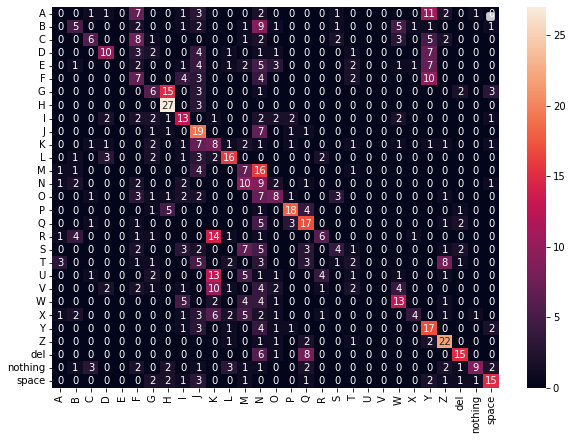

In [190]:
preds_test = stats_test['preds']
plot_conf_mat(preds_test, ind_to_class)
print(f"Exactitud en test externo: {round(float(stats_test['correct'])/stats_test['total'], 3)}")

La exactitud lograda (correctos en totales) sobre un conjunto de test externo es bajísima. Esto verifica que el conjunto de datos utilizado para el desafío está lejos de ser útil para generar un modelo que aprenda a reconocer símbolos del alfabeto del lenguaje de sígnos, al menos sin aplicar algun tipo de aumento de datos.

Solo para verificar que estoy usando la instancia del modelo correcta calculo la matriz de confusión y la exactitud sobre el conjunto de validación.

In [191]:
stats_val = evaluate(CNN_model, val_dataloader, criterion)

  0%|          | 0/272 [00:00<?, ?it/s]

No handles with labels found to put in legend.


Exactitud en validación: 0.851


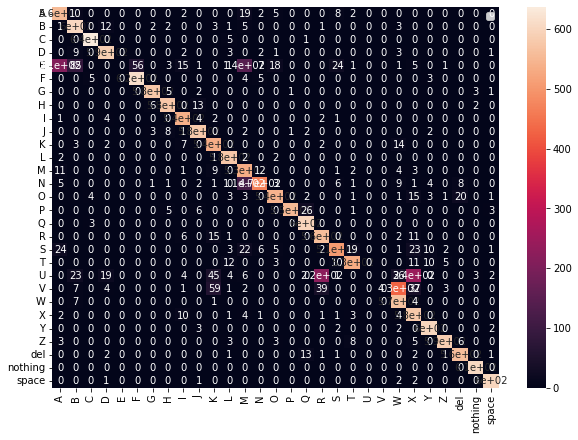

In [124]:
preds_val = stats_val['preds']
plot_conf_mat(preds_val, ind_to_class)
print(f"Exactitud en validación: {round(float(stats_val['correct'])/stats_val['total'], 3)}")

Efectivamente, la instancia del modelo es correcta, sin embargo, es evidente que se ha sobreajustado a un conjunto con varianza muy reducida, haciendo dificil que el modelo pueda generalizar y funcionar bien con elementos que no son parecidos a los utilizados para entrenar. Esto quedará observable de mejor manera cuando se implemente la API para probar con otras imágenes.